# Oneway Analysis of Y by X


In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import math

from scipy import stats
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
#@title #Download File and Select Data

#@markdown Make sure the file containing the data you wish to analyze is in your Google Drive
file_type = "xlsx" #@param ["csv", "xlsx"]
file_name = 'Hot Dogs.xlsx' #@param ["estradiol.csv", "Hot Dogs.xlsx"] {type:"string", allow-input: true}
# Hot Dogs.xlsx
#@markdown Check the below box to inspect the imported data.
show_frame = True #@param {type:"boolean"}

file_path = f"/content/drive/MyDrive/{file_name}"

match file_type:
  case "csv":
    data = pd.read_csv(file_path)
  case "xlsx":
    data = pd.read_excel(file_path)

#@markdown ---
data if show_frame else ""


,Product Name,Type,Taste,$/oz,$/lb Protein,Calories,Sodium,Protein/Fat
0,Happy Hill Supers,Beef,Bland,0.11,14.23,186,495,1
1,Georgies Skinless Beef,Beef,Bland,0.17,21.70,181,477,2
2,Special Market's Premium Beef,Beef,Bland,0.11,14.49,176,425,1
3,Spike's Beef,Beef,Medium,0.15,20.49,149,322,1
4,Hungry Hugh's Jumbo Beef,Beef,Medium,0.10,14.47,184,482,1
5,Great Dinner Beef,Beef,Medium,0.11,15.45,190,587,1
6,RJB Kosher Beef,Beef,Medium,0.21,25.25,158,370,2
7,Wonder Kosher Skinless Beef,Beef,Medium,0.20,24.02,139,322,2
8,Happy Fats Jumbo Beef,Beef,Medium,0.14,18.86,175,479,1
9,Midwest Beef,Beef,Medium,0.14,18.86,148,375,1


In [ ]:
#@title #Select X, Factor and Y, Response

#@markdown Make sure the variable names are spelled correctly and without quotation marks! Reference the table printed above.
X_name = "Protein/Fat" #@param {type:"string"}
Y_name = "Sodium" #@param {type:"string", allow-input: true}
# Hot Dogs.xlsx
print("Confirm that the variables have been selected correctly.")
data[[X_name, Y_name]]

Confirm that the variables have been selected correctly.


,Protein/Fat,Sodium
0,1,495
1,2,477
2,1,425
3,1,322
4,1,482
5,1,587
6,2,370
7,2,322
8,1,479
9,1,375


## Define Functions

In [ ]:
def r_squared(*groups):
  all_data = pd.concat(groups)
  mean_all = np.mean(all_data)
  sst = np.sum((all_data - mean_all)**2)

  ssb = 0
  for grp in groups:
    ssb += len(grp) * (np.mean(grp) - mean_all)**2

  return ssb / sst

def adj_r_squared(*groups):
  rsquared = r_squared(*groups)
  all_data = pd.concat(groups)

  k = len(groups)

  N = len(all_data)

  return 1 - ((1-rsquared)*(N-1)/(N - k - 1))

def rmse(*groups):
  ssw = 0
  for grp in groups:
    ssw += np.sum((grp - np.mean(grp))**2)

  N = len(pd.concat(groups))
  k = len(groups)

  return np.sqrt(ssw/(N-k))

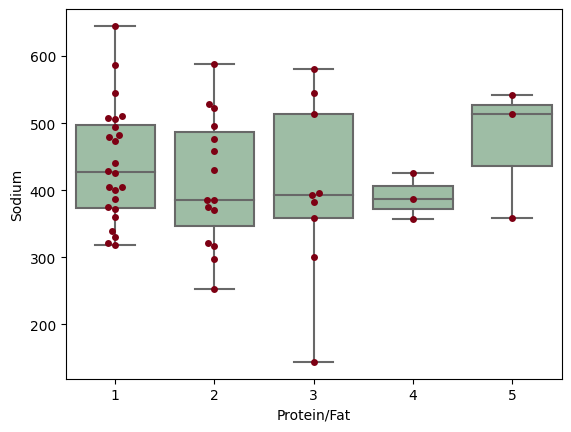

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x=X_name, y=Y_name, data=data, color='#99c2a2')
ax = sns.swarmplot(x=X_name, y=Y_name, data=data, color='#7d0013')
plt.show()

## Oneway Anova

### Summary of Fit

In [ ]:
grouped_data = [data[data[X_name] == grp][Y_name] for grp in data[X_name].unique()]

In [ ]:
sof_data = {
    'Rsquare': r_squared(*grouped_data),
    'Adj Rsquare': adj_r_squared(*grouped_data),
    'Root Mean Square Error': rmse(*grouped_data),
    'Mean of Response': np.mean(pd.concat(grouped_data)),
    'Observations': len(pd.concat(grouped_data)),
}

sof = pd.Series(data=sof_data)
sof = sof.to_frame()
sof.style.set_caption("Summary of Fit")

,0
Rsquare,0.044707
Adj Rsquare,-0.054802
Root Mean Square Error,97.438170
Mean of Response,424.833333
Observations,54.000000


### Analysis of Variance

In [ ]:
f_ratio, p_value = stats.f_oneway(*grouped_data)

In [ ]:
df_total = len(pd.concat(grouped_data)) - 1
df_within = len(pd.concat(grouped_data)) - len(grouped_data)
df_between = len(grouped_data) - 1

anova_data = {
    'Source': [X_name, 'Error', 'C. Total'],
    'DF': [len(grouped_data) - 1, len(pd.concat(grouped_data)) - len(grouped_data), len(pd.concat(grouped_data)) - 1],
    'Sum of Squares':[0, 0, '-'],
    'Mean Square': [0, 0, '-'],
    'F Ratio': [f_ratio, '-' , '-'],
    'Prob > F': [p_value, '-', '-']
}

#Sum of Squares

#Treatment
for grp in grouped_data:
  anova_data['Sum of Squares'][0] += len(grp) * (np.mean(grp) - np.mean(pd.concat(grouped_data)))**2

#Error
for grp in grouped_data:
  anova_data['Sum of Squares'][1] += len(grp) * np.var(grp)

#Total
anova_data['Sum of Squares'][2] = sum(anova_data['Sum of Squares'][0:2])


#Mean Square
anova_data['Mean Square'][0] = anova_data['Sum of Squares'][0]/(len(grouped_data)-1)
anova_data['Mean Square'][1] = anova_data['Sum of Squares'][1]/(len(pd.concat(grouped_data)) - len(grouped_data))


anova = pd.DataFrame(data=anova_data)
anova.style.set_caption("Analysis of Variance")

,Source,DF,Sum of Squares,Mean Square,F Ratio,Prob > F
0,Protein/Fat,4,21771.844444,5442.961111,0.573293,0.683276
1,Error,49,465215.655556,9494.197052,-,-
2,C. Total,53,486987.500000,-,-,-


### Means for Oneway Anova

In [ ]:
means_data = {
    'Level': data[X_name].unique(),
    'Number': [len(grp) for grp in grouped_data],
    'Mean': [np.mean(grp) for grp in grouped_data],
    'Std Error': [rmse(*grouped_data)/np.sqrt(len(grp)) for grp in grouped_data],
    'Lower 95%': [stats.t.interval(
        0.95, #Confidence
        len(pd.concat(grouped_data)) - len(grouped_data), #Deg freedom
        np.mean(grp), #Grp mean
        rmse(*grouped_data)/np.sqrt(len(grp)))[0] #Grp std err
                  for i, grp in enumerate(grouped_data)],
    'Upper 95%': [stats.t.interval(
        0.95, #Confidence
        len(pd.concat(grouped_data)) - len(grouped_data), #Deg freedom
        np.mean(grp), #Grp mean
        rmse(*grouped_data)/np.sqrt(len(grp)))[1] #Grp std err
                  for i, grp in enumerate(grouped_data)],

}
means = pd.DataFrame(data=means_data)
means.style.set_caption("Means for Oneway Anova")

,Level,Number,Mean,Std Error,Lower 95%,Upper 95%
0,1,24,439.083333,19.889483,399.113920,479.052746
1,2,15,413.733333,25.158427,363.175581,464.291086
2,3,9,401.444444,32.479390,336.174666,466.714222
3,4,3,390.000000,56.255954,276.949428,503.050572
4,5,3,471.333333,56.255954,358.282762,584.383905


## Means Comparisons for All Pairs Using Tukey-Kramer HSD

### Confidence Quantile

In [ ]:
q_star = (1/np.sqrt(2))*stats.studentized_range.ppf(1-0.05,len(grouped_data),df_within)

q_data = {
    # q* = (1/sqrt(2))*q, where q = Alpha percentile of studentized range distribution
    'q*': [q_star],
    'Alpha': [0.05]

}

conf_quant = pd.DataFrame(data=q_data)
conf_quant.style.set_caption("Confidence Quantile")

,q*,Alpha
0,2.831941,0.050000


### HSD Threshold Matrix

In [ ]:
MSw = anova_data['Sum of Squares'][1]/(len(pd.concat(grouped_data)) - len(grouped_data))

pooled_n = len(grouped_data[0])

np.sqrt(MSw/pooled_n) * stats.studentized_range.ppf(1-0.05,len(grouped_data),df_within)

hsd_matrix = np.zeros((len(grouped_data),len(grouped_data)))

for i in range(hsd_matrix.shape[0]):
  for j in range(hsd_matrix.shape[1]):
    if i == j:
      pooled_n = 1/len(grouped_data[i])
    else:
      pooled_n = 0.5* (1/len(grouped_data[i]) + 1/len(grouped_data[j]))
    mean_dif = np.abs(np.mean(grouped_data[i]) - np.mean(grouped_data[j]))
    hsd_matrix[i,j] = mean_dif - np.sqrt(MSw*pooled_n) * stats.studentized_range.ppf(1-0.05,len(grouped_data),df_within)

hsd_frame = pd.DataFrame(data=hsd_matrix, columns=data[X_name].unique(), index=data[X_name].unique())

hsd_frame.style.set_caption("Abs(Dif) - HSD")

,1,2,3,4,5
1,-79.656772,-65.472694,-70.216890,-119.894197,-136.727530
2,-65.472694,-100.758732,-104.057273,-150.785910,-116.919243
3,-70.216890,-104.057273,-130.078963,-172.514990,-114.070545
4,-119.894197,-150.785910,-172.514990,-225.303374,-143.970040
5,-136.727530,-116.919243,-114.070545,-143.970040,-225.303374


### Ordered Differences Report

In [187]:
import itertools

combinations = list(itertools.combinations(grouped_data, 2))
level_combinations = list(itertools.combinations(data[X_name].unique(), 2))
index_combinations = list(itertools.combinations([i for i in range(len(grouped_data))], 2))
print(len(index_combinations))

#Std Err Dif
# rmse(*grouped_data)/np.sqrt(len(combo[1])) - rmse(*grouped_data)/np.sqrt(len(combo[0]))



ord_data = {
    '(Level 1, Level 2)': [t for t in level_combinations],
    'Difference': [np.abs(t[0].mean() - t[1].mean()) for t in combinations],
    'Std Err Dif': [((rmse(*grouped_data)/np.sqrt(len(t[0])))**2 + (rmse(*grouped_data)/np.sqrt(len(t[1])))**2)**0.5 for t in combinations],
    'Lower CL': [0 for t in index_combinations],
    'Upper CL': [0 for t in index_combinations],
    'p-Value': [stats.tukey_hsd(*grouped_data).pvalue[t[0],t[1]] for t in index_combinations]
}

for i in range(len(combinations)):
  ord_data['Lower CL'][i] = ord_data['Difference'][i] - q_star * ord_data['Std Err Dif'][i]
  ord_data['Upper CL'][i] = ord_data['Difference'][i] + q_star * ord_data['Std Err Dif'][i]

ord_table = pd.DataFrame(data=ord_data)
ord_table = ord_table.sort_values('Difference', ascending=False)
ord_table.style.set_caption("Ordered Differences Report")

10


,"(Level 1, Level 2)",Difference,Std Err Dif,Lower CL,Upper CL,p-Value
9,"(4, 5)",81.333333,79.557933,-143.970040,306.636707,0.843856
8,"(3, 5)",69.888889,64.958780,-114.070545,253.848323,0.817933
6,"(2, 5)",57.600000,61.625310,-116.919243,232.119243,0.881983
2,"(1, 4)",49.083333,59.668450,-119.894197,218.060864,0.922383
1,"(1, 3)",37.638889,38.085461,-70.216890,145.494668,0.859319
3,"(1, 5)",32.250000,59.668450,-136.727530,201.227530,0.982598
0,"(1, 2)",25.350000,32.070828,-65.472694,116.172694,0.932186
5,"(2, 4)",23.733333,61.625310,-150.785910,198.252576,0.995184
4,"(2, 3)",12.288889,41.083540,-104.057273,128.635051,0.998195
7,"(3, 4)",11.444444,64.958780,-172.514990,195.403879,0.999776


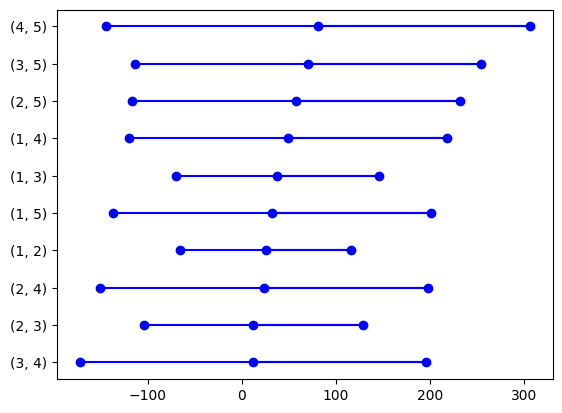

In [189]:
ord_table2 = ord_table.sort_values('Difference', ascending=True)

for lower, center, upper,y in zip(ord_table2['Lower CL'],ord_table2['Upper CL'],ord_table2['Difference'],range(len(ord_table2))):
    plt.plot((lower,center, upper),(y,y,y),'bo-')
plt.yticks(range(len(ord_table2)),list(ord_table2['(Level 1, Level 2)']))
plt.show()

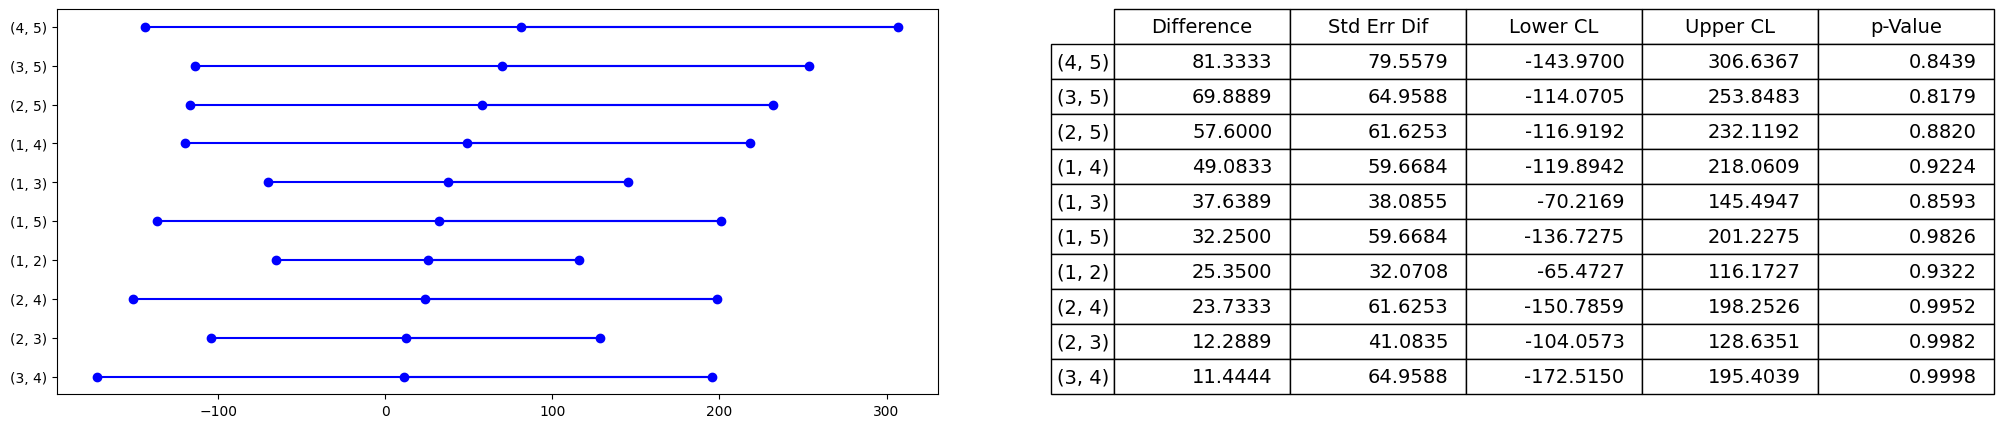

In [202]:
fig = plt.figure(figsize=(25,5))
ord_table2 = ord_table.sort_values('Difference', ascending=True)
ord_table_precise = ord_table[['Difference', 'Std Err Dif', 'Lower CL', 'Upper CL', 'p-Value']].applymap('{:,.4f}'.format)
ord_table_precise.set_index(ord_table['(Level 1, Level 2)'], inplace=True)


ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = ord_table_precise.values, rowLabels = ord_table_precise.index, bbox=bbox, colLabels=ord_table_precise.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

ax1 = fig.add_subplot(121)
for lower, center, upper,y in zip(ord_table2['Lower CL'],ord_table2['Upper CL'],ord_table2['Difference'],range(len(ord_table2))):
    ax1.plot((lower,center, upper),(y,y,y),'bo-')
ax1.set_yticks(range(len(ord_table2)),list(ord_table2['(Level 1, Level 2)']))
plt.show()